In [1]:
import numpy as np
import igl
import pybcclean as pbc
import networkx as nx
from scipy.spatial import cKDTree as KDTree
import meshplot as mp
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pbc_utilities as pbcut

In [59]:
parent_dir = "../data/"+str(2)+"/"
bad_obj_file = pbcut.get_bad_mesh(parent_dir)
dmat_file = parent_dir+"feat.dmat"
good_obj_file = parent_dir + "good.mesh__sf.obj"
v_bad, f_bad=igl.read_triangle_mesh(bad_obj_file)
fl_bad  = igl.read_dmat(dmat_file)
v_good, f_good = igl.read_triangle_mesh(good_obj_file)

print("read")
fl_bad=fl_bad.astype('int32')
f_good = f_good.astype('int32')
f_bad = f_bad.astype('int32')
label_num = fl_bad.max()+1
# prob_mat, fl_good = pbc.project_face_labels(v_bad, f_bad, fl_bad,label_num,2, v_good, f_good)
# fl_refine = pbc.refine_labels(v_good, f_good, prob_mat, fl_good.astype('int32'),1)[:,0]
# print("refine")
# v_good, f_good = igl.upsample(v_good, f_good, 2)
edge_list_bad, patch_edge_list_bad = pbc.build_edge_list(v_bad, f_bad, fl_bad, label_num)
node_list_bad = pbc.build_node_list(f_bad, fl_bad, label_num)
# prob_mat, fl_good = pbc.project_face_labels(v_bad, f_bad, fl_bad,label_num,2, v_good, f_good)
# fl_refine = pbc.refine_labels(v_good, f_good, prob_mat, fl_good.astype('int32'),1)[:,0]
# print("refine")
G_bad_ini = nx.Graph()
G_bad_ini.add_nodes_from(list(range(len(v_bad))))
G_bad_ini.add_edges_from([tuple(a) for a in igl.edges(f_bad)])
G_bad = nx.Graph()
G_bad.add_nodes_from(list(range(len(v_bad))))
G_bad.add_edges_from([tuple(a) for a in igl.edges(f_bad)])
G_good = nx.Graph()
G_good.add_nodes_from(list(range(len(v_good))))
G_good.add_edges_from([tuple(a) for a in igl.edges(f_good)])
print(len(edge_list_bad))

read
32


In [60]:
def initialize_attributes(G, v, node_list, edge_list):
    node_idx_list = [nd.vidx for nd in node_list]
    for vidx in G.nodes():
        G.nodes[vidx]["position"]=v[vidx].copy()
        G.nodes[vidx]["edge_list"] = [] 
        # if it is an NNode more than three edges counter clockwise according to outgoing normal
        if( not vidx in node_idx_list):
            G.nodes[vidx]["is_node"] = False
        else:
            G.nodes[vidx]["is_node"] = True
    for j, edg in enumerate(edge_list):
        for v in edg.vertices_list:
            if not j in G.nodes[v]["edge_list"]:
                G.nodes[v]["edge_list"].append(j)
                
def recur_func(G, v, node_list, edge_list, head):
    tree_head = nx.bfs_tree(G, head)
    source_edge_idices = G.nodes[head]["edge_list"]
#     print("find", head ,"on edge", source_edge_idices)
    tail = -1
    fake_edge = pbc.Edge()
    if len(source_edge_idices) != 2:
        # temp node of valance 2
        return False
    target_edge_idx = -1
    for tx, ty in tree_head.edges():
        if len(G.nodes[ty]["edge_list"]) == 1:
            print("called")
            target_edge_idx=G.nodes[ty]["edge_list"][0]
            if not target_edge_idx in source_edge_idices:
                tail = ty
                path = nx.shortest_path(tree_head, source=head, target=tail)
                fake_edge.head = head
                fake_edge.tail = tail
                fake_edge.vertices_list = path
                
                break
    if target_edge_idx == -1:
        return False
    fake_node_tail = pbc.Node()
    fake_node_tail.vidx = tail
    node_list.append(fake_node_tail)
    edge_list.append(fake_edge)
    target_edge = edge_list[target_edge_idx]
    if target_edge.head != -1 and target_edge.tail != -1:
        # break it into two
        target_edge0 = pbc.Edge()
        target_edge0.head = target_edge.head
        target_edge0.tail = tail
        target_edge0.vertices_list = []
        target_edge1 = pbc.Edge()
        target_edge1.head = tail
        target_edge1.tail = target_edge.tail
        target_edge1.vertices_list = []
        bench = -1
        for j, vidx in enumerate(target_edge.vertices_list):
            if vidx == tail:
                bench = j
        target_edge0.vertices_list = target_edge.vertices_list[:bench+1]
        target_edge1.vertices_list = target_edge.vertices_list[bench:] 
        edge_list.pop(target_edge_idx) # remove the old edge
        edge_list.append(target_edge0)
        edge_list.append(target_edge1)
        initialize_attributes(G, v, node_list, edge_list)
        return True
    else:
        return False
    
    
    
    
def add_fake_node_edge(G, v, node_list, edge_list):
    node_idx_list = [nd.vidx for nd in node_list]
    loops = []
    for j, edg in enumerate(edge_list):
        if(edg.head == edg.tail):
            loops.append(j)
    #break all the loops in the frame
    
    fake_node_idx = []
    count = 0
    for lp in reversed(sorted(loops)):
        count +=1
        loop = edge_list[lp]
        head = loop.vertices_list[0]
        mid = loop.vertices_list[len(loop.vertices_list) // 2]
        fake_node_idx.append(head)
        fake_node_idx.append(mid)
        fake_node_head = pbc.Node()
        fake_node_head.vidx = head
        fake_node_mid = pbc.Node()
        fake_node_mid.vidx = mid
        node_list.append(fake_node_head)
        node_list.append(fake_node_mid)
        bench = -1
        for j, vidx in enumerate(loop.vertices_list):
            if vidx == mid:
                bench = j
        if bench == -1:
            return False
        target_edge0 = pbc.Edge()
        target_edge0.head = head
        target_edge0.tail = mid
        target_edge0.vertices_list = loop.vertices_list[: bench+1]
        target_edge1 = pbc.Edge()
        target_edge1.head = mid
        target_edge1.tail = head
        target_edge1.vertices_list = loop.vertices_list[bench:]+[loop.vertices_list[0]]
        edge_list.pop(lp)
        edge_list.append(target_edge0)
        edge_list.append(target_edge1)
#         print(count, "count")
#         print(target_edge1.vertices_list, target_edge0.vertices_list)
    
    initialize_attributes(G,v,node_list, edge_list)
    for root in fake_node_idx:
        if(not recur_func(G, v, node_list, edge_list, root)):
            return False
    return True
    

In [61]:
# print(add_fake_node_edge(G_bad, v_bad, node_list_bad, edge_list_bad))
initialize_attributes(G_bad, v_bad, node_list_bad, edge_list_bad)
for nd in node_list_bad:
    print(nd.vidx, G_bad.nodes[nd.vidx]["edge_list"])
# ff_bad, I_bad=pbc.reorient(v_bad, f_bad) // usually not necessary

18 [28, 29, 31]
19 [26, 27, 30]
16 [23, 24, 27]
15 [22, 23, 28]
13 [19, 20, 26, 29]
12 [17, 18, 19, 30]
11 [14, 15, 20, 31]
9 [9, 10, 24]
10 [10, 11, 17]
8 [11, 12, 16, 18]
6 [5, 6, 9]
5 [6, 7, 12]
3 [2, 3, 5]
2 [1, 2, 22]
1 [0, 1, 15]
0 [0, 4, 13, 14]
4 [3, 4, 8]
7 [7, 8, 13, 16]


In [96]:
add_fake_node_edge(G_bad, v_bad, node_list_bad, edge_list_bad)
for nd in node_list_bad:
    print(nd.vidx, G_bad.nodes[nd.vidx]["edge_list"])

18 [22, 23, 25]
19 [20, 21, 24]
16 [19, 21, 31]
15 [18, 19, 22]
13 [16, 17, 20, 23]
12 [15, 16, 24, 37]
11 [13, 17, 25, 41]
9 [8, 9, 32]
10 [9, 10, 15]
8 [10, 11, 14, 38]
6 [4, 5, 8]
5 [5, 6, 11]
3 [2, 4, 35]
2 [1, 18, 34]
1 [0, 1, 13]
0 [0, 3, 12, 40]
4 [2, 3, 7]
7 [6, 7, 12, 14]
17 [26, 27, 30]
808 [26, 27, 33]
14 [28, 29, 36]
595 [28, 29, 39]
732 [30, 31, 32]
71 [33, 34, 35]
456 [36, 37, 38]
390 [39, 40, 41]


In [97]:
print(len(edge_list_bad))
node_bad = [nd.vidx for nd in node_list_bad]
p_bad = mp.subplot(v_bad, f_bad,s= [2,2,0],shading={"wireframe":False})
p_bad.rows[0][0].add_points(v_bad[node_bad], shading={"point_size": 3})
for edg in edge_list_bad:
    p_bad.rows[0][0].add_points(v_bad[edg.vertices_list],shading={"point_size": 1})

42


In [64]:
node_bad=[nd.vidx for nd in node_list_bad]
node_face_dict=pbcut.CC_faces_per_node(v_bad, f_bad, node_bad)
node_outedge_dict = {}
for key in node_face_dict:
    node_outedge_dict[key]= []
    for fidx in node_face_dict[key]:
        pool = list(f_bad[fidx])
        bench = -1
        for i, v_f in enumerate(pool):
            if v_f == key:
                bench = i
                break
        outedge = [pool[i], pool[(i+1)%3]]
        node_outedge_dict[key].append(outedge)

node_CC_edge_dict = {}
for key in node_outedge_dict:
    node_CC_edge_dict[key]=[]
    edge_pool = G_bad.nodes[key]["edge_list"].copy()
    for outedge in node_outedge_dict[key]:
        testv = outedge[1]
        for i, edg_idx in enumerate(edge_pool):
            edg = edge_list_bad[edg_idx]
            if (testv in edg.vertices_list ) and edg_idx not in node_CC_edge_dict[key]:
                node_CC_edge_dict[key].append(edg_idx)
    G_bad.nodes[key]["edge_list"] = node_CC_edge_dict[key]
print(node_CC_edge_dict)   
                

adjacency detcted
{18: [23, 22, 25], 19: [20, 24, 21], 16: [21, 31, 19], 15: [22, 19, 18], 13: [23, 17, 16, 20], 12: [24, 16, 37, 15], 11: [17, 25, 13, 41], 9: [9, 8, 32], 10: [9, 15, 10], 8: [14, 11, 10, 38], 6: [4, 8, 5], 5: [6, 5, 11], 3: [35, 4, 2], 2: [1, 18, 34], 1: [1, 0, 13], 0: [12, 40, 0, 3], 4: [3, 2, 7], 7: [12, 7, 6, 14], 17: [26, 30, 27], 808: [27, 26, 33], 14: [28, 36, 29], 595: [29, 39, 28], 732: [32, 30, 31], 71: [34, 33, 35], 456: [38, 37, 36], 390: [41, 40, 39]}


In [81]:
def arc_length_sample(v:np.array, edg:pbc.Edge, num:int):
    
    diffs=v[edg.vertices_list[1:]]-v[edg.vertices_list[:-1]]
    norm_list = [np.linalg.norm(dx) for dx in diffs]
    arc_list = []
    ss = 0
    res = np.zeros((num+1,3))
    for nm in norm_list:
        arc_list.append(ss)
        ss += nm
    for i in range(num+1):
        bench = i*ss/num
        count =0
        lbda0 = 0
        lbda1 = 1
        for arc0, arc1 in zip(arc_list[:-1], arc_list[1:]):
            if arc0 <= bench and arc1 >= 0:
                lbda0 = (bench - arc0)/ norm_list[count]
                lbda1 = (arc1 - bench)/ norm_list[count]
                break
            count += 1
        
        res[i]=v[edg.vertices_list[count]]* lbda0+ v[edg.vertices_list[count+1]]* lbda1
    return res

def rbf(radius:float, v_good:np.array, edg:pbc.Edge, num:int):
    sample = arc_length_sample(v_bad, edg, num)
    lambda x, y: int(np.linalg.norm(x-y)>radius) * np.linalg.norm(x-y)
    
def edge_weight(G_good:nx.Graph,v_bad:np.array, v_good:np.array, edg:pbc.Edge, num:int):
#     weight = np.zeros((len(G_good.edges),0))
    sample = arc_length_sample(v_bad, edg, num)
    kdt_sample=KDTree(sample)
    distances=kdt_sample.query(v_good)[0]
    weight = np.array([max(distances[edg_good[0]], distances[edg_good[1]]) for edg_good in G_good.edges])
    return weight

def split_triangle_pair(G, v, f, uidx, vidx):
    # handle v
    new_v = (v[vidx]+ v[uidx])/2
    new_v_idx = len(v)
    # append to v
    v = np.vstack([v, new_v])
    
    # handle f
    vf, ni=igl.vertex_triangle_adjacency(f, len(v)-1)
    nd_f_num_u = ni[uidx+1]-ni[uidx] # number of faces adjacent to nd
    fnbu = [vf[ni[uidx]+j] for j in range(nd_f_num_u)]
    nd_f_num_v = ni[vidx+1]-ni[vidx] # number of faces adjacent to nd
    fnbv = [vf[ni[vidx]+j] for j in range(nd_f_num_v)]
    finter = [val for val in fnbv if val in fnbu]
    assert(len(finter) == 2)
    
    u_local_idx = -1
    v_local_idx = -1
    x  = -1
    y = -1
    fx = -1
    fy = -1
    for i, v_f in enumerate(f[finter[0]]):
        if v_f == uidx:
            u_local_idx = i
        elif v_f == vidx:
            v_local_idx = i
    if((u_local_idx+1)% 3 == v_local_idx):
        fx = finter[0]
        fy = finter[1]
    for v_f in f[fx]:
        if v_f != uidx and v_f != vidx:
            x = v_f
    for v_f in f[fy]:
        if v_f != uidx and v_f != vidx:
            y = v_f
    f=np.delete(f, [fx, fy], axis= 0)
    f0 = np.array([x, uidx, new_v_idx])
    f1 = np.array([uidx, y, new_v_idx])
    f2 = np.array([y, vidx, new_v_idx])
    f3 = np.array([vidx, x, new_v_idx])
    f = np.vstack([f, f0, f1, f2, f3])
#     print("add",len(f))
    # handle G
    G.add_node(new_v_idx)
    G.remove_edge(uidx, vidx)
    G.add_edges_from([(x, new_v_idx), (uidx, new_v_idx), (vidx, new_v_idx), (y, new_v_idx)])
    G.nodes[new_v_idx]["position"]= new_v
    G.nodes[new_v_idx]["edge_list"] = [] 
    G.nodes[vidx]["is_node"] = False
    return G, v, f

def bridge_detect(G):
    res = []
    for u,v in G.edges():
        if len(G.nodes[u]["edge_list"])==1 and len(G.nodes[v]["edge_list"])==1:
            if G.nodes[u]["edge_list"][0]!= G.nodes[v]["edge_list"][0]:
                res.append((u,v))
                
    return res

def bridge_detect2(G):
    res = []
    for u,v in G.edges():
        if len(G.nodes[u]["edge_list"])==1 and len(G.nodes[v]["edge_list"])==1:
            if G.nodes[u]["edge_list"][0]!= G.nodes[v]["edge_list"][0]:
                return u, v
                
    return -1, -1

In [66]:
node_dict = {}
kdt_good = KDTree(v_good)
for nd in node_list_bad:
    node_dict[nd.vidx] = kdt_good.query(v_bad[nd.vidx])[1]
print(node_dict)

{18: 229, 19: 56, 16: 139, 15: 117, 13: 78, 12: 1366, 11: 1127, 9: 144, 10: 157, 8: 1205, 6: 132, 5: 147, 3: 371, 2: 445, 1: 433, 0: 995, 4: 440, 7: 450, 17: 21, 808: 512, 14: 32, 595: 367, 732: 143, 71: 710, 456: 148, 390: 1128}


In [95]:
sample_num = 1000
v_good_copy = v_good.copy()
f_good_copy = f_good.copy()
G_good_copy = G_good.copy()
# deep copy are necessary


    
initialize_attributes(G_good_copy, v_good_copy, [],[])
print(len(v_good_copy))
p = mp.subplot(v_good, f_good,s= [2,2,0],shading={"wireframe":False})
for edg_idx, edg in enumerate(reversed(edge_list_bad)):
    print("for edg", edg_idx)
    if (edg.head == -1 and edg.tail == -1):
        print("minus")
        continue
    head = node_dict[edg.head]
    tail = node_dict[edg.tail]
    sample = arc_length_sample(v_bad, edg, sample_num)
    kdt_sample=KDTree(sample)
    distances=kdt_sample.query(v_good_copy)[0]
    def func(u,v, d): 
        return np.linalg.norm(v_good_copy[u]-v_good_copy[v])*pow(max(distances[u],distances[v],0.000001), 1)
    path=nx.shortest_path(G_good_copy, source=head, target=tail, weight = func)
#     print(path)
    for v in path:
        G_good_copy.nodes[v]["edge_list"].append(edg_idx)
    bridges = bridge_detect(G_good_copy)
    pathedge = [[x,y] for x, y in zip (path[1:],path[:-1])]
    print(bridges)
    for uidx, vidx in bridges:
#         print("called")
        G_good_copy, v_good_copy, f_good_copy=split_triangle_pair(G_good_copy, v_good_copy, f_good_copy, uidx, vidx)
        print(len(v_good_copy))
    
    p.rows[0][0].add_edges(v_good_copy,np.array(pathedge, dtype = 'int64'),shading={"line_width": 4.0,"line_color": "red"})
#   
    if parent_dir == "../data/"+str(2)+"/":
        G_good_copy.remove_nodes_from(path[1:-1])
#     print(v_good_copy[path])
#     p.rows[0][0].add_points(v_good_copy[path],shading={"point_size": 1})
        
        # #     pathedge = [[x,y] for x, y in zip (path[1:],path[:-1])]
    
#     G_good_copy.remove_nodes_from(path[1:-1])
# p = mp.subplot(v_good, f_good,np.array([2,3,4]) ,s= [2,2,0],shading={"wireframe":False})
# p.rows[0][0].add_points(v_good[node_good], shading={"point_size": 3})
# Gp = G_good.copy()
# count = -1
# for edg in edge_list_bad[:15]:
#         head = node_dict[edg.head]
#         tail = node_dict[edg.tail]
#         sample = arc_length_sample(v_bad, edg, sample_num)
#         kdt_sample=KDTree(sample)
#         distances=kdt_sample.query(v_good)[0]
#         func = lambda u,v, d: np.linalg.norm(v_good[u]-v_good[v])*pow(max(distances[u],distances[v],0.000001), 1)
#         path=nx.shortest_path(Gp, source=head, target=tail, weight=func)
#         pathedge = [[x,y] for x, y in zip (path[1:],path[:-1])]
#         if count != 14:
#             p.rows[0][0].add_edges(v_good,np.array(pathedge, dtype = 'int64'),shading={"line_width": 4.0,"line_color": "red"})
#         else:
#             p.rows[0][0].add_edges(v_good,np.array(pathedge, dtype = 'int64'),shading={"line_width": 4.0,"line_color": "red"})
#         Gp.remove_nodes_from(path[1:-1])

1497


for edg 0
[]
for edg 1
[]
for edg 2
[]
for edg 3
[]
for edg 4
[]
for edg 5
[(871, 1366)]
1498
for edg 6
[]
for edg 7
[]
for edg 8


/Users/vector_cat/anaconda3/envs/bcclean_dev/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: in the future negative indices will not be ignored by `numpy.delete`.


[]
for edg 9
[]
for edg 10
[]
for edg 11
[]
for edg 12
[]
for edg 13
[]
for edg 14
[]
for edg 15
[]
for edg 16
[]
for edg 17
[]
for edg 18
[]
for edg 19
[]
for edg 20
[]
for edg 21
[]
for edg 22
[]
for edg 23
[]
for edg 24
[]
for edg 25
[]
for edg 26
[]
for edg 27
[]
for edg 28
[]
for edg 29
[]
for edg 30
[]
for edg 31
[]
for edg 32
[]
for edg 33
[]
for edg 34
[]
for edg 35
[]
for edg 36
[]
for edg 37
[]
for edg 38
[]
for edg 39
[]
for edg 40
[]
for edg 41
[]


$$
\begin{align}
\sqrt{37} & = \sqrt{\frac{73^2-1}{12^2}} \\
 & = \sqrt{\frac{73^2}{12^2}\cdot\frac{73^2-1}{73^2}} \\ 
 & = \sqrt{\frac{73^2}{12^2}}\sqrt{\frac{73^2-1}{73^2}} \\
 & = \frac{73}{12}\sqrt{1 - \frac{1}{73^2}} \\ 
 & \approx \frac{73}{12}\left(1 - \frac{1}{2\cdot73^2}\right)
\end{align}
$$

In [6]:
def arc_length_sample(v:np.array, edg:pbc.Edge, num:int):
    
    diffs=v[edg.vertices_list[1:]]-v[edg.vertices_list[:-1]]
    norm_list = [np.linalg.norm(dx) for dx in diffs]
    arc_list = []
    ss = 0
    res = np.zeros((num+1,3))
    for nm in norm_list:
        arc_list.append(ss)
        ss += nm
    for i in range(num+1):
        bench = i*ss/num
        count =0
        lbda0 = 0
        lbda1 = 1
        for arc0, arc1 in zip(arc_list[:-1], arc_list[1:]):
            if arc0 <= bench and arc1 >= 0:
                lbda0 = (bench - arc0)/ norm_list[count]
                lbda1 = (arc1 - bench)/ norm_list[count]
                break
            count += 1
        
        res[i]=v[edg.vertices_list[count]]* lbda0+ v[edg.vertices_list[count+1]]* lbda1
    return res
                
def edge_weight(G_good:nx.Graph,v_bad:np.array, v_good:np.array, edg:pbc.Edge, num:int):
#     weight = np.zeros((len(G_good.edges),0))
    sample = arc_length_sample(v_bad, edg, num)
    kdt_sample=KDTree(sample)
    distances=kdt_sample.query(v_good)[0]
    weight = np.array([max(distances[edg_good[0]], distances[edg_good[1]]) for edg_good in G_good.edges])
    return weight
   
    

In [31]:
vf_bad, ni_bad = igl.vertex_triangle_adjacency(f_bad, len(v_bad))

In [203]:
x=np.vstack([[[1,2,3],[3,4,5]],[1,1,1]])
np.delete(x, [1])


array([1, 3, 3, 4, 5, 1, 1, 1])

In [54]:
for edg in edge_list_bad:
    head = edg.head
    tail = edg.tail
    if (head !=-1 and tail != -1):
        path=nx.shortest_path(G_bad, source=head, target=tail)
        pathedge = [[x,y] for x, y in zip (path[1:],path[:-1])]

        d.rows[0][0].add_edges(v_bad,np.array(pathedge, dtype = 'int64') )

In [88]:
x = np.array([1,2,3])
np.linalg.norm(x)

3.7416573867739413

In [61]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,2),(2,3),(3,4),(4,1), (1,5),(2,5),(3,5),(4,5)])

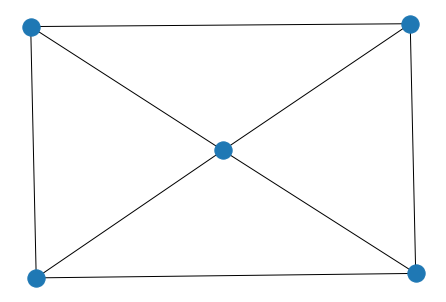

In [62]:
import matplotlib.pyplot as plt
# G.remove_nodes_from([5])
nx.draw(G)

In [64]:
G.remove_node(5)

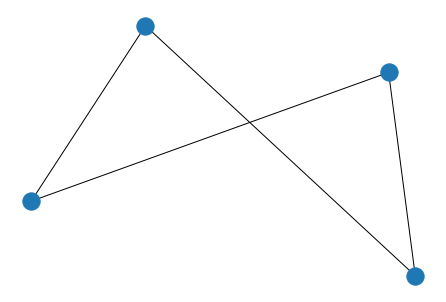

In [65]:
nx.draw(G)

In [140]:
?nx.dijkstra_path

In [38]:
?igl.dihedral_angles_intrinsic

In [8]:
import matplotlib.pyplot as plt

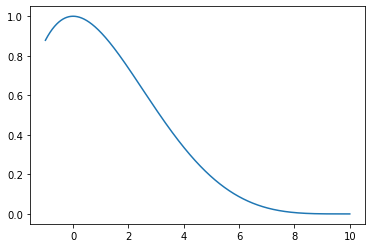

In [17]:
x = np.arange(-1,10,0.001)
def funcc(r, h):
    return pow(1-r/h, 4) * (4 * (r/h) +1)
h =10
y = [funcc(xx, h) for xx in x]
plt.plot(x, y)
